In [1]:
!pip install transformers
!pip install accelerate
!pip install datasets
!pip install scikit-multilearn
!pip install nlpaug
!pip install sacremoses
!pip install faiss-cpu
!pip install faiss-gpu


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 265.7/265.7 kB 1.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 507.1/507.1 kB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 3.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 3.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.4/89.4 kB 1.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.5/410.5 kB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 897.5/897.5 kB 5.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.6/17.6 MB 55.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.5/85.5 MB 11.0 MB/s eta 0:00:00


In [2]:
from huggingface_hub import notebook_login

notebook_login()

### Dealing With Few To No Labels

<h1> Do you have labeled data ? </h1>
<ul>
<li> No: Zero-shot learning</li>
<h2> <li> Yes: How many labels ?</li></h2>
<ul>
<li> A Lot: Fine-tune model</li>
<h3> <li> A Few: Do you have unlabeled data ?</li></h3>
<ul>
<li> Yes: {Domain adaption, UDA/UST}</li>
<li> No: {Embeddding lookup, Few-shot learning}</li>
</ul>
</ul>
</ul>

In [3]:
import time
import math
import requests
from pathlib import Path
import pandas as pd
from tqdm.auto import tqdm

def fetch_issues(owner="huggingface", repo="transformers", num_issues=10_000,
                 rate_limit=5_000):
    batch = []
    all_issues = []
    per_page = 100 # Number of issues to return per page
    num_pages = math.ceil(num_issues / per_page)
    base_url = "https://api.github.com/repos"

    for page in tqdm(range(num_pages)):
        # Qury with state=all to get both open and closed issues
        query = f"issues?page={page}&per_page={per_page}&state=all"
        issues = requests.get(f"{base_url}/{owner}/{repo}/{query}")
        batch.extend(issues.json())

        if len(batch) > rate_limit and len(all_issues) < num_issues:
            all_issues.extend(batch)
            batch = [] # Flush batch for next time period
            print(f"Reached Github rate limit. Sleeping for one hour ... ")
            time.sleep(60 * 60 + 1)

    all_issues.extend(batch)
    df = pd.DataFrame.from_records(all_issues)
    df.to_json(f"github-issues-{repo}.jsonl", orient="records", lines=True)


In [4]:
# fetch_issues()

### Preparing the Data

In [5]:
import pandas as pd

dataset_url = "https://git.io/nlp-with-transformers"
df_issues = pd.read_json(dataset_url, lines=True)
print(f"DataFrame shape : {df_issues.shape}")

DataFrame shape : (9930, 26)


In [6]:
cols = ["url", "id", "title", "user", "labels", "state", "created_at", "body"]
df_issues.loc[2, cols].to_frame()

,2
url,https://api.github.com/repos/huggingface/trans...
id,849529761
title,[DeepSpeed] ZeRO stage 3 integration: getting ...
user,"{'login': 'stas00', 'id': 10676103, 'node_id':..."
labels,"[{'id': 2659267025, 'node_id': 'MDU6TGFiZWwyNj..."
state,open
created_at,2021-04-02 23:40:42
body,"**[This is not yet alive, preparing for the re..."


In [7]:
df_issues["labels"] = (df_issues["labels"]
                       .apply(lambda x: [meta["name"] for meta in x]))
df_issues[["labels"]].head()

,labels
0,[]
1,[]
2,[DeepSpeed]
3,[]
4,[]


In [8]:
df_issues["labels"].apply(lambda x: len(x)).value_counts().to_frame().T

,0,1,2,3,4,5
labels,6440,3057,305,100,25,3


In [9]:
df_counts = df_issues["labels"].explode().value_counts()
print(f"Number of labels: {len(df_counts)}")

# Display the top-8 label categories
df_counts.to_frame().head(8).T

Number of labels: 65


,wontfix,model card,Core: Tokenization,New model,Core: Modeling,Help wanted,Good First Issue,Usage
labels,2284,649,106,98,64,52,50,46


In [10]:
label_map = {"Core: Tokenization": "tokenization",
             "New model": "new model",
             "Core: Modeling": "model training",
             "Usage": "usage",
             "Core: Pipeline": "pipeline",
             "TensorFlow": "tensorflow or tf",
             "PyTorch": "pytorch",
             "Examples": "examples",
             "Documentation": "documentation"}

def filter_labels(x):
    return [label_map[label] for label in x if label in label_map]

df_issues["labels"] = df_issues["labels"].apply(filter_labels)
all_labels = list(label_map.values())

In [11]:
df_counts = df_issues["labels"].explode().value_counts()
df_counts.to_frame().T


,tokenization,new model,model training,usage,pipeline,tensorflow or tf,pytorch,documentation,examples
labels,106,98,64,46,42,41,37,28,24


In [12]:
df_issues["split"] = "unlabeled"
mask = df_issues["labels"].apply(lambda x: len(x)) > 0
df_issues.loc[mask, "split"] = "labeled"
df_issues["split"].value_counts().to_frame()

,split
unlabeled,9489
labeled,441


In [13]:
for column in ["title", "body", "labels"]:
    print(f"{column}: {df_issues[column].iloc[26][:500]}\n")

title: Add new CANINE model

body: # 🌟 New model addition

## Model description

Google recently proposed a new **C**haracter **A**rchitecture with **N**o tokenization **I**n **N**eural **E**ncoders architecture (CANINE). Not only the title is exciting:

> Pipelined NLP systems have largely been superseded by end-to-end neural modeling, yet nearly all commonly-used models still require an explicit tokenization step. While recent tokenization approaches based on data-derived subword lexicons are less brittle than manually en

labels: ['new model']



In [14]:
df_issues["text"] = (df_issues
                     .apply(lambda x: x["title"] + "\n\n" + x["body"], axis=1))

In [15]:
len_before = len(df_issues)
df_issues = df_issues.drop_duplicates(subset="text")
print(f"Removed {(len_before - len(df_issues)) / len_before:.2%} duplicates.")

Removed 1.88% duplicates.


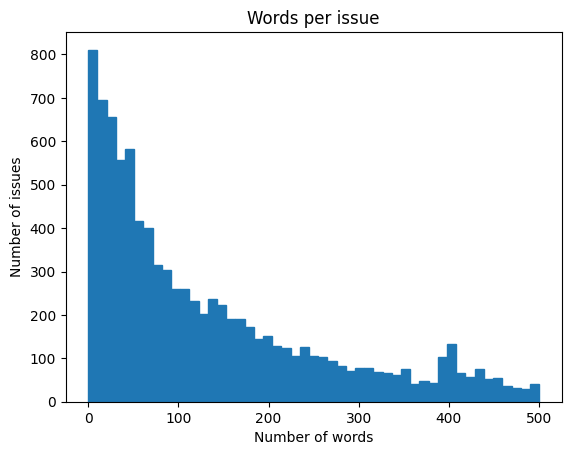

In [16]:
import numpy as np
import matplotlib.pyplot as plt

(df_issues["text"].str.split().apply(len)
    .hist(bins=np.linspace(0, 500, 50), grid=False, edgecolor="C0"))
plt.title("Words per issue")
plt.xlabel("Number of words")
plt.ylabel("Number of issues")
plt.show()

### Creating Training Sets

In [17]:
from sklearn.preprocessing import MultiLabelBinarizer

mlb = MultiLabelBinarizer()
mlb.fit([all_labels])
mlb.transform([["tokenization", "new model"], ["pytorch"]])

array([[0, 0, 0, 1, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 1, 0, 0, 0]])

In [18]:
from skmultilearn.model_selection import iterative_train_test_split

def balanced_split(df, test_size=0.5):
    ind = np.expand_dims(np.arange(len(df)), axis=1)
    labels = mlb.transform(df["labels"])
    ind_train, _, ind_test, _ = iterative_train_test_split(ind, labels,
                                                           test_size)
    return df.iloc[ind_train[:, 0]], df.iloc[ind_test[:, 0]]

In [19]:
from sklearn.model_selection import train_test_split

df_clean = df_issues[["text", "labels", "split"]].reset_index(drop=True).copy()
df_unsup = df_clean.loc[df_clean["split"] == "unlabeled", ["text", "labels"]]
df_sup = df_clean.loc[df_clean["split"] == "labeled", ["text", "labels"]]

np.random.seed(0)
df_train, df_tmp = balanced_split(df_sup, test_size=0.5)
df_valid, df_test = balanced_split(df_tmp, test_size=0.5)

In [20]:
from datasets import Dataset, DatasetDict

ds = DatasetDict({
    "train": Dataset.from_pandas(df_train.reset_index(drop=True)),
    "valid": Dataset.from_pandas(df_valid.reset_index(drop=True)),
    "test": Dataset.from_pandas(df_test.reset_index(drop=True)),
    "unsup": Dataset.from_pandas(df_unsup.reset_index(drop=True))
    })

### Creating Training Slices

In [21]:
np.random.seed(0)
all_indices = np.expand_dims(list(range(len(ds["train"]))), axis=1)
indices_pool = all_indices
labels = mlb.transform(ds["train"]["labels"])
train_samples = [8, 16, 32, 64, 128]
train_slices, last_k = [], 0

for i, k in enumerate(train_samples):
    # Split off samples necessary to fill the gap to the next split size
    indices_pool, labels, new_slice, _ = iterative_train_test_split(
        indices_pool, labels, (k - last_k) / len(labels))
    last_k = k

    if i==0:
        train_slices.append(new_slice)
    else:
        train_slices.append(np.concatenate((train_slices[-1], new_slice)))

# Add full dataset as last slice
train_slices.append(all_indices)
train_slices = [np.squeeze(train_slice) for train_slice in train_slices]

train_samples.append(len(ds["train"]))

In [22]:
print("Target split sizes: ")
print(train_samples)
print("Actual split sizes: ")
print([len(x) for x in train_slices])

Target split sizes: 
[8, 16, 32, 64, 128, 223]
Actual split sizes: 
[10, 19, 36, 68, 134, 223]


### Implementing a Naive Bayesline

In [23]:
def prepare_labels(batch):
    batch["label_ids"] = mlb.transform([batch["labels"]])
    return batch

ds = ds.map(prepare_labels, batch_size=True)

Map:   0%|          | 0/223 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/111 [00:00<?, ? examples/s]

Map:   0%|          | 0/9303 [00:00<?, ? examples/s]

In [24]:
from collections import defaultdict

macro_scores, micro_scores = defaultdict(list), defaultdict(list)

In [25]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report
from skmultilearn.problem_transform import BinaryRelevance
from sklearn.feature_extraction.text import CountVectorizer

for train_slice in train_slices:
    # Get training slice and test data
    ds_train_sample = ds["train"].select(train_slice)

    y_train = np.array(ds_train_sample["label_ids"])
    y_train = y_train.reshape((-1, y_train.shape[-1]))

    y_test = np.array(ds["test"]["label_ids"])
    y_test = y_test.reshape((-1, y_test.shape[-1]))


    # Use a simple count vectorizer to encode our texts as token counts
    count_vect = CountVectorizer()
    X_train_counts = count_vect.fit_transform(ds_train_sample["text"])
    X_test_counts = count_vect.transform(ds["test"]["text"])

    # Create and train our model!
    classifier = BinaryRelevance(classifier=MultinomialNB())
    classifier.fit(X_train_counts, y_train)

    # Generate predictions and evaluate
    y_pred_test = classifier.predict(X_test_counts)
    clf_report = classification_report(
        y_test, y_pred_test, target_names=mlb.classes_, zero_division=0,
        output_dict=True)

    # Store metrics
    macro_scores["Naive Bayes"].append(clf_report["macro avg"]["f1-score"])
    micro_scores["Naive Bayes"].append(clf_report["micro avg"]["f1-score"])

In [26]:
import matplotlib.pyplot as plt

def plot_metrics(micro_scores, macro_score, sample_sizes, current_model):
    fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(10, 4), sharey=True)

    for run in micro_scores.keys():
        if run == current_model:
            ax0.plot(sample_sizes, micro_scores[run], label=run, linewidth=2)
            ax1.plot(sample_sizes, macro_scores[run], label=run, linewidth=2)

        else:
            ax0.plot(sample_sizes, micro_scores[run], label=run,
                     linestyle="dashed")
            ax1.plot(sample_sizes, macro_scores[run], label=run,
                     linestyle="dashed")

    ax0.set_title("Micro F1 scores")
    ax0.set_ylabel("Test set F1 score")
    ax0.legend(loc="lower right")

    ax1.set_title("Macro F1 scores")
    ax1.set_ylabel("Test set F1 score")
    ax1.legend(loc="lower right")

    for ax in [ax0, ax1]:
        ax.set_xlabel("Number of training samples")
        ax.set_xscale("log")
        ax.set_xticks(sample_sizes)
        ax.set_xticklabels(sample_sizes)
        ax.minorticks_off()

    plt.tight_layout
    plt.show()

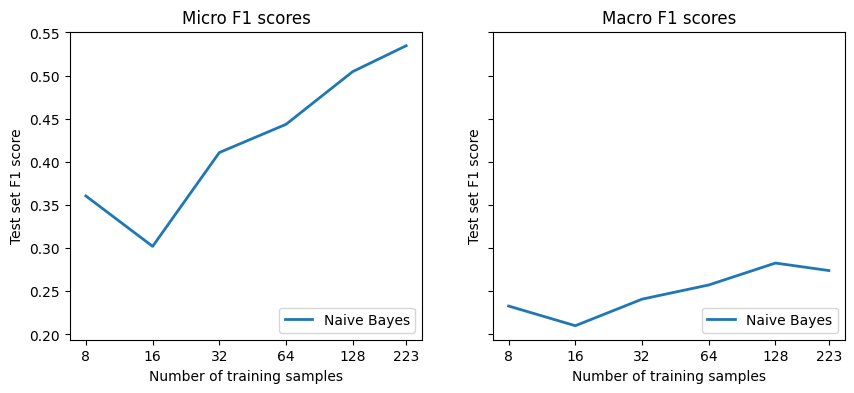

In [27]:
plot_metrics(micro_scores, macro_scores, train_samples, "Naive Bayes")

### Working with No Labeled Data

In [55]:
from transformers import pipeline

pipe = pipeline("fill-mask", model="bert-base-uncased")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:72: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [56]:
movie_desc = """
The main characters of the movie madacascar \
are a lion, a zebra, a giraffe, and a hippo.
"""
prompt = "The movie is about [MASK]."

output = pipe(movie_desc + prompt)
for element in output:
    print(f"Token {element['token_str']}:\t{element['score']:.3f}%")

Token animals:	0.103%
Token lions:	0.066%
Token birds:	0.025%
Token love:	0.015%
Token hunting:	0.013%


In [57]:
output = pipe(movie_desc + prompt, targets=["animals", "cars"])

for element in output:
    print(f"Token {element['token_str']}:\t{element['score']:.3f}%")

Token animals:	0.103%
Token cars:	0.001%


In [58]:
movie_desc = """
In the movie transformers aliens \
can morph into a wide range of vehicles.
"""
prompt = "The movie is about [MASK]."

output = pipe(movie_desc + prompt, targets=["animals", "cars"])
for element in output:
    print(f"Token {element['token_str']}:\t{element['score']:.3f}%")

Token cars:	0.139%
Token animals:	0.006%


In [ ]:
from transformers import pipeline

pipe = pipeline("zero-shot-classification", device=0)

No model was supplied, defaulted to facebook/bart-large-mnli and revision c626438 (https://huggingface.co/facebook/bart-large-mnli).
Using a pipeline without specifying a model name and revision in production is not recommended.


config.json:   0%|          | 0.00/1.15k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

RuntimeError: ignored

In [ ]:
sample = ds["train"][0]
print(f"Label: {sample['labels']}")

output = pipe(sample['text'], all_labels, multi_label=True)
print(output["sequence"][:400])
print("\nPredictions:")

for label, score in zip(output["labels"], output["scores"]):
    print(f"{label}, {score}:.2f")

In [ ]:
def zero_shot_pipeline(example):
    output = pipe(example["text"], all_labels, multi_label=True)
    example["predicted_labels"] = output["labels"]
    example["scores"] = output["scores"]
    return example

ds_zero_shot = ds["valid"].map(zero_shot_pipeline)

In [ ]:
def get_preds(example, threshold=None, top_k=None):
    preds = []
    if threshold:
        for label, score in zip(example["predicted_labels"], example["scores"]):
            if score >= threshold:
                preds.append(label)

    elif top_k:
        for i in range(top_k):
            preds.append(example["predicted_labels"][i])

    else:
        raise ValueError("Set either 'Threshold' or 'Top_K'.")

    return {"pred_label_ids": list(np.squeeze(mlb.transform([preds])))}

In [ ]:
def get_clf_report(ds):
    y_true = np.array(ds["label_ids"])
    y_true = np.squeeze(y_true)

    y_pred = np.array(ds["pred_label_ids"])
    return classification_report(y_true, y_pred, target_names=mlb.classes_,
                                 zero_division=0, output_dict=True)

In [ ]:
macros, micros = [], []
top_ks = [1, 2, 3, 4]

for top_k in top_ks:
    ds_zero_shot = ds_zero_shot.map(get_preds, batched=False,
                                    fn_kwargs={"top_k": top_k})
    clf_report = get_clf_report(ds_zero_shot)
    micros.append(clf_report["micro avg"]["f1-score"])
    macros.append(clf_report["macro avg"]["f1-score"])

In [ ]:
plt.plot(top_ks, micros, label="Micro F1")
plt.plot(top_ks, macros, label="Macro F1")
plt.xlabel("Top-K")
plt.ylabel("F1-Score")
plt.legend(loc="best")
plt.show()

In [ ]:
macros, micros = [], []
thresholds = np.linspace(0.01, 1, 100)
for threshold in thresholds:
    ds_zero_shot = ds_zero_shot.map(get_preds,
                                    fn_kwargs={"threshold": threshold})
    clf_report = get_clf_report(ds_zero_shot)
    micros.append(clf_report["micro avg"]["f1-score"])
    macros.append(clf_report["macro avg"]["f1-score"])

In [ ]:
plt.plot(thresholds, micros, label="Micro F1")
plt.plot(thresholds, macros, label="Macro F1")
plt.xlabel("Thresold")
plt.ylabel("F1-Score")
plt.legend(loc="best")
plt.show()

In [ ]:
best_t, best_micro = thresholds[np.argmax(micros)], np.max(micros)
print(f"Best threshold (micro): {best_t} with f1-score {best_micro:.2f}.")

best_t, best_macro = thresholds[np.argmax(macros)], np.max(macros)
print(f"Best threshold (macro): {best_t} with f1-score {best_macro:.2f}.")

In [ ]:
ds_zero_shot = ds["test"].map(zero_shot_pipeline)
ds_zero_shot = ds_zero_shot.map(get_preds, fn_kwargs={"top_k": 1})
clf_report = get_clf_report(ds_zero_shot)
for train_slice in train_slices:
    macro_scores["Zero Shot"].append(clf_report["macro avg"]["f1-score"])
    micro_scores["Zero Shot"].append(clf_report["micro avg"]["f1-score"])

In [ ]:
plot_metrics(micro_scores, macro_scores, train_samples, "Zero Shot")

### Working with a Few Labels

#### Data Augmentation

In [ ]:
from transformers import set_seed
import nlpaug.augmenter.word as naw
import nlpaug.augmenter.char as nac
import nlpaug.augmenter.sentence as nas
import nlpaug.flow as nafc
import nltk

In [ ]:
nltk.download("averaged_perceptron_tagger")
nltk.download("wordnet")

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [ ]:
set_seed(3)
text = "Even if you defeat me Megatron, others will rise to defeat your tyranny"
augs = {}

##### Text Augmentation
<ul>
<li> synonym replacement
<li> random insert
<li> random swap
<li> random delete
<li> Translation from to language
</ul>

In [ ]:
augs["synonym_replace"] = naw.SynonymAug(aug_src='wordnet')

augs["random_insert"] = naw.ContextualWordEmbsAug(model_path="distilbert-base-uncased",
                                                  device="cpu",
                                                  action="insert",
                                                  aug_max=1)

augs["random_swap"] = naw.RandomWordAug(action="swap")
augs["random_delete"] = naw.RandomWordAug()

augs["bt_en_de"] = naw.BackTranslationAug(from_model_name='facebook/wmt19-en-de',
                                          to_model_name='facebook/wmt19-de-en')

for k,v in augs.items():
    print(f"Original text: {text}")
    print(f"{k}: {v.augment(text)}")
    print("")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:72: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Some weights of FSMTForConditionalGeneration were not initialized from the model checkpoint at facebook/wmt19-en-de and are newly initialized: ['model.encoder.embed_positions.weight', 'model.decoder.embed_positions.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of FSMTForConditionalGeneration were not initialized from the model checkpoint at facebook/wmt19-de-en and are newly initialized: ['m

Original text: Even if you defeat me Megatron, others will rise to defeat your tyranny
synonym_replace: ['Even if you vote down me Megatron, others will turn out to defeat your tyranny']

Original text: Even if you defeat me Megatron, others will rise to defeat your tyranny
random_insert: ['even if you defeat me megatron, others will rise to finally defeat your tyranny']

Original text: Even if you defeat me Megatron, others will rise to defeat your tyranny
random_swap: ['Even if you defeat Megatron me, others to will rise defeat your tyranny']

Original text: Even if you defeat me Megatron, others will rise to defeat your tyranny
random_delete: ['Even if me Megatron, will rise to tyranny']

Original text: Even if you defeat me Megatron, others will rise to defeat your tyranny
bt_en_de: ['Even if you defeat me, others will rise up to defeat your tyranny']



In [ ]:
from transformers import set_seed
import nlpaug.augmenter.word as naw

set_seed(3)
aug = naw.ContextualWordEmbsAug(model_path="distilbert-base-uncased",
                                device="cuda",
                                action="substitute")

text = "Transformers are the most popular toys"
print(f"Original text: {text}")
print(f"Augmented text: {aug.augment(text)}")

Original text: Transformers are the most popular toys
Augmented text: ['transformers produce the most famous toys']


In [ ]:
def augment_text(batch, transformations_per_example=1):
    text_aug, label_ids = [], []
    for text, labels in zip(batch["text"], batch["label_ids"]):
        text_aug += [text]
        label_ids += [labels]
        for _ in range(transformations_per_example):
            text_aug += aug.augment(text)
            label_ids += [labels]

    return {"text": text_aug, "label_ids": label_ids}

In [ ]:
for train_slice in train_slices:
    # Get training slice test data
    ds_train_sample = ds["train"].select(train_slice)

    # Flatten augmentataions and align labels!
    ds_train_aug = (ds_train_sample.map(
        augment_text, batched=True, remove_columns=ds_train_sample.column_names)
        .shuffle(seed=42))

    y_train = np.array(ds_train_aug["label_ids"])
    y_train = y_train.reshape((-1, y_train.shape[-1]))

    y_test = np.array(ds["test"]["label_ids"])
    y_test = y_test.reshape((-1, y_test.shape[-1]))

    # Use a simple count vectorizer to encode our texts as token counts
    count_vect = CountVectorizer()
    X_train_counts = count_vect.fit_transform(ds_train_aug["text"])
    X_test_counts = count_vect.transform(ds["test"]["text"])

    # Create and train our model!
    classifier = BinaryRelevance(classifier=MultinomialNB())
    classifier.fit(X_train_counts, y_train)

    # Generate predictions and evaluate
    y_pred_test = classifier.predict(X_test_counts)

    clf_reprot = classification_report(y_test, y_pred_test,
                                       target_names=mlb.classes_,
                                       zero_division=0,
                                       output_dict=True)

    # Store metrics
    macro_scores["Naive Bayes + Aug"].append(clf_report["macro avg"]["f1-score"])
    micro_scores["Naive Bayes + Aug"].append(clf_report["micro avg"]["f1-score"])

Map:   0%|          | 0/10 [00:00<?, ? examples/s]

Map:   0%|          | 0/19 [00:00<?, ? examples/s]

Map:   0%|          | 0/36 [00:00<?, ? examples/s]

Map:   0%|          | 0/68 [00:00<?, ? examples/s]

Map:   0%|          | 0/134 [00:00<?, ? examples/s]

Map:   0%|          | 0/223 [00:00<?, ? examples/s]

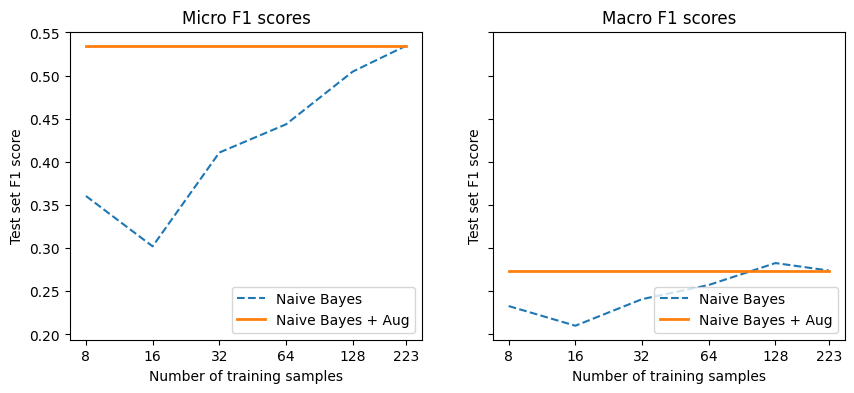

In [ ]:
plot_metrics(micro_scores, macro_scores, train_samples, "Naive Bayes + Aug")

### Using Embeddings as a Lookup Table


In [ ]:
import torch
from transformers import AutoTokenizer, AutoModel

model_ckpt = "miguelvictor/python-gpt2-large"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)
model = AutoModel.from_pretrained(model_ckpt)

def mean_pooling(model_output, attention_mask):
    # Extract the token embeddings
    token_embeddings = model_output[0]

    # Compute the attention mask
    input_mask_expanded = (attention_mask
                           .unsqueeze(-1)
                           .expand(token_embeddings.size())
                           .float())

    # Sum the embeddings, but ignore the masked tokens
    sum_embeddings = torch.sum(token_embeddings * input_mask_expanded, 1)
    sum_mask = torch.clamp(input_mask_expanded.sum(1), min=1e-9)

    # Return the average as a single vector
    return sum_embeddings / sum_mask

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:72: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [ ]:
def embeded_text(examples):
    inputs = tokenizer(examples["text"], padding=True,
                       truncation=True,
                       max_length=128,
                       return_tensors="pt")

    with torch.no_grad():
        model_output = model(**inputs)

    pooled_embeds = mean_pooling(model_output, inputs["attention_mask"])
    return {"embedding": pooled_embeds.cpu().numpy()}

In [ ]:
tokenizer.pad_token = tokenizer.eos_token

embs_train = ds["train"].map(embeded_text, batched=True, batch_size=16)
embs_valid = ds["valid"].map(embeded_text, batched=True, batch_size=16)
embs_test = ds["test"].map(embeded_text, batched=True, batch_size=16)

Map:   0%|          | 0/223 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/111 [00:00<?, ? examples/s]

In [ ]:
embs_train.add_faiss_index("embedding")

  0%|          | 0/1 [00:00<?, ?it/s]

Dataset({
    features: ['text', 'labels', 'label_ids', 'embedding'],
    num_rows: 223
})

In [ ]:
i, k = 0, 3 # Select the first query and 3 nearest neighbors
rn, nl = "\r\n\r\n", "\n" # Used to remove newlines in text for compact display

query = np.array(embs_valid[i]["embedding"], dtype=np.float32)
scores, samples = embs_train.get_nearest_examples("embedding", query, k=k)

print(f"QURY LABELS: {embs_valid[i]['labels']}")
print(f"QURY TEXT:\n {embs_valid[i]['text'][:200].replace(rn, nl)}[...]\n")
print("="*50)
print(f"Retrieved documents: ")
for score, label, text in zip(scores, samples["labels"], samples["text"]):
    print("="*50)
    print(f"TEXT: \n{text[:200].replace(rn, nl)}[...]")
    print(f"SCORE: {score:.2f}")
    print(f"LABEL: {label}")

QURY LABELS: ['new model']
QURY TEXT:
 Implementing efficient self attention in T5

# 🌟 New model addition
My teammates and I (including @ice-americano) would like to use efficient self attention methods such as Linformer, Performer and[...]

Retrieved documents: 
TEXT: 
Add Linformer model

# 🌟 New model addition
## Model description
### Linformer: Self-Attention with Linear Complexity
Paper published June 9th on ArXiv: https://arxiv.org/abs/2006.04768
La[...]
SCORE: 54.92
LABEL: ['new model']
TEXT: 
Add FAVOR+ / Performer attention

# 🌟 FAVOR+ / Performer attention addition
Are there any plans to add this new attention approximation block to Transformers library?
## Model description
The n[...]
SCORE: 57.90
LABEL: ['new model']
TEXT: 
Implement DeLighT: Very Deep and Light-weight Transformers

# 🌟 New model addition
## Model description
DeLight, that delivers similar or better performance than transformer-based models with sign[...]
SCORE: 60.12
LABEL: ['new model']


In [ ]:
def get_sample_preds(sample, m):
    return (np.sum(sample["label_ids"], axis=0) >= m).astype(int)

In [ ]:
def find_best_k_m(ds_train, valid_queries, valid_labels, max_k=17):
    max_k = min(len(ds_train), max_k)
    perf_micro = np.zeros((max_k, max_k))
    perf_macro = np.zeros((max_k, max_k))
    for k in range(1, max_k):
        for m in range(1, k + 1):
            _, samples = ds_train.get_nearest_examples_batch("embedding",
                                                             valid_queries,
                                                             k=k)

            y_pred = np.array([get_sample_preds(s, m) for s in samples])

            valid_labels = valid_labels.reshape((-1, valid_labels.shape[-1]))
            y_pred = y_pred.reshape((-1, y_pred.shape[-1]))

            clf_report = classification_report(valid_labels, y_pred,
                                               target_names=mlb.classes_,
                                               zero_division=0,
                                               output_dict=True)

            perf_micro[k, m] = clf_report["micro avg"]["f1-score"]
            perf_macro[k, m] = clf_report["macro avg"]["f1-score"]
    return perf_micro, perf_macro

In [ ]:
valid_labels = np.array(embs_valid["label_ids"])
valid_queries = np.array(embs_valid["embedding"], dtype=np.float32)
perf_micro, perf_macro = find_best_k_m(embs_train, valid_queries, valid_labels)

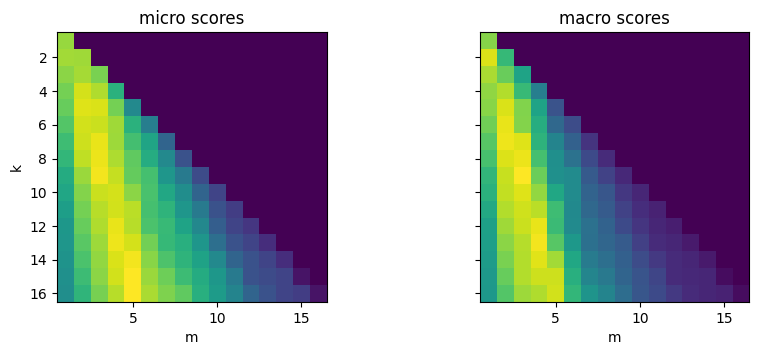

In [ ]:
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(10, 3.5), sharey=True)
ax0.imshow(perf_micro)
ax1.imshow(perf_macro)

ax0.set_title("micro scores")
ax0.set_ylabel("k")

ax1.set_title("macro scores")
for ax in [ax0, ax1]:
    ax.set_xlim([0.5, 17 - 0.5])
    ax.set_ylim([17 - 0.5, 0.5])
    ax.set_xlabel("m")

plt.show()

In [ ]:
k, m = np.unravel_index(perf_micro.argmax(), perf_micro.shape)
print(f"Best k: {k}, best m: {m}")

Best k: 15, best m: 5


In [ ]:
embs_train.drop_index("embedding")
test_labels = np.array(embs_test["label_ids"])
test_queries = np.array(embs_test["embedding"], dtype=np.float32)

for train_slice in train_slices:
    # Create a FAISS index from training slice
    embs_train_tmp = embs_train.select(train_slice)
    embs_train_tmp.add_faiss_index("embedding")

    # Get best k, m values with validation set
    perf_micro, _ = find_best_k_m(embs_train_tmp, valid_queries, valid_labels)
    k, m = np.unravel_index(perf_micro.argmax(), perf_micro.shape)

    # Get predictions on test set
    _, samples = embs_train_tmp.get_nearest_examples_batch("embedding",
                                                           test_queries,
                                                           k=int(k))
    y_pred = np.array([get_sample_preds(s, m) for s in samples])

    test_labels = test_labels.reshape((-1, test_labels.shape[-1]))
    y_pred = y_pred.reshape((-1, y_pred.shape[-1]))

    # Evaluate predictions
    clf_report = classification_report(test_labels, y_pred,
                                       target_names=mlb.classes_,
                                       zero_division=0,
                                       output_dict=True)
    macro_scores["Embedding"].append(clf_report["macro avg"]["f1-score"])
    micro_scores["Embedding"].append(clf_report["micro avg"]["f1-score"])

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

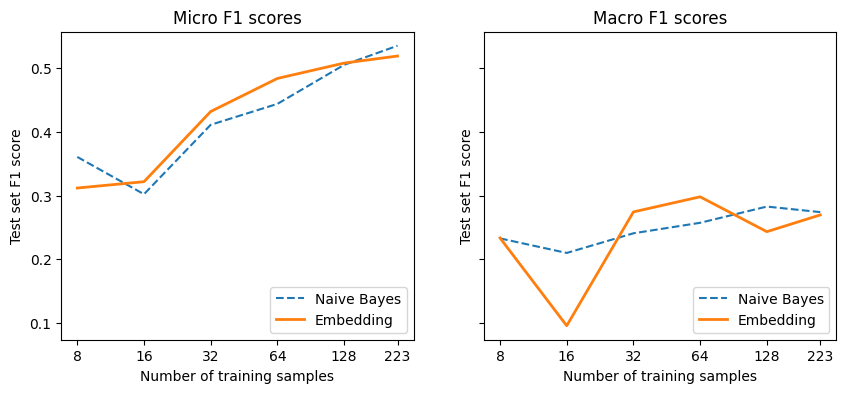

In [ ]:
plot_metrics(micro_scores, macro_scores, train_samples, "Embedding")


### Fine-Tuning a Vanilla Transformer


In [59]:
import torch
from transformers import (AutoTokenizer, AutoConfig,
                          AutoModelForSequenceClassification)

model_ckpt = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

def tokenize(batch):
    return tokenizer(batch["text"], truncation=True, max_length=128)

ds_enc = ds.map(tokenize, batched=True)
ds_enc = ds_enc.remove_columns(["labels", "text"])

Map:   0%|          | 0/223 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/111 [00:00<?, ? examples/s]

Map:   0%|          | 0/9303 [00:00<?, ? examples/s]

In [60]:
ds_enc.set_format("torch")
ds_enc = ds_enc.map(lambda x: {"label_ids_f": x["label_ids"]
                               .reshape((x["label_ids"].shape[-1],))
                               .to(torch.float)},
                    remove_columns=["label_ids"])

ds_enc = ds_enc.rename_column("label_ids_f", "label_ids")

Map:   0%|          | 0/223 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/111 [00:00<?, ? examples/s]

Map:   0%|          | 0/9303 [00:00<?, ? examples/s]

In [61]:
ds_enc["train"]["label_ids"].shape

torch.Size([223, 9])

In [62]:
from scipy.special import expit as sigmoid

def compute_metrics(pred):
    y_true = pred.label_ids
    y_pred = sigmoid(pred.predictions)
    y_pred = (y_pred>0.5).astype(float)

    clf_dict = classification_report(y_true, y_pred, target_names=all_labels,
                                     zero_division=0, output_dict=True)

    return {"micro f1": clf_dict["micro avg"]["f1-score"],
            "macro f1": clf_dict["macro avg"]["f1-score"]}

In [63]:
from transformers import Trainer, TrainingArguments

training_args_fine_tune = TrainingArguments(output_dir="./results",
                                            num_train_epochs=20,
                                            learning_rate=3e-5,
                                            lr_scheduler_type="constant",
                                            per_device_train_batch_size=4,
                                            per_device_eval_batch_size=32,
                                            weight_decay=0.0,
                                            evaluation_strategy="epoch",
                                            save_strategy="epoch",
                                            logging_strategy="epoch",
                                            save_total_limit=1,
                                            log_level="error")

In [64]:
config = AutoConfig.from_pretrained(model_ckpt)
config.num_labels = len(all_labels)
config.problem_type = "multi_label_classification"

In [ ]:
for train_slice in train_slices:
    model = AutoModelForSequenceClassification.from_pretrained(model_ckpt,
                                                               config=config)

    trainer = Trainer(model=model,
                      tokenizer=tokenizer,
                      args=training_args_fine_tune,
                      compute_metrics=compute_metrics,
                      train_dataset=ds_enc["train"].select(train_slice),
                      eval_dataset=ds_enc["valid"])

    trainer.train()

    pred = trainer.predict(ds_enc["test"])

    metrics = compute_metrics(pred)
    macro_scores["Fine-tune (vanilla)"].append(metrics["macro f1"])
    micro_scores["Fine-tune (vanilla)"].append(metrics["micro f1"])

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Micro f1,Macro f1
1,0.653000,0.596579,0.089385,0.039770
2,0.574100,0.560975,0.016129,0.007407
3,0.545700,0.525749,0.000000,0.000000
4,0.509100,0.497357,0.000000,0.000000
5,0.460500,0.463767,0.000000,0.000000
6,0.427600,0.440860,0.000000,0.000000
7,0.404100,0.422777,0.000000,0.000000
8,0.383500,0.402181,0.000000,0.000000
9,0.357200,0.399550,0.000000,0.000000
10,0.363800,0.380419,0.000000,0.000000


Epoch,Training Loss,Validation Loss,Micro f1,Macro f1
1,0.620900,0.562027,0.053333,0.012121
2,0.525900,0.507853,0.015267,0.006349
3,0.484500,0.449506,0.000000,0.000000
4,0.429900,0.419669,0.000000,0.000000
5,0.396300,0.397261,0.000000,0.000000
6,0.364300,0.384147,0.000000,0.000000
7,0.351700,0.374146,0.000000,0.000000
8,0.336700,0.370720,0.000000,0.000000
9,0.320100,0.364471,0.000000,0.000000
10,0.316700,0.363771,0.000000,0.000000


Epoch,Training Loss,Validation Loss,Micro f1,Macro f1
1,0.579600,0.510832,0.031008,0.013468
2,0.470500,0.444572,0.000000,0.000000
3,0.406200,0.395712,0.000000,0.000000
4,0.373800,0.377313,0.000000,0.000000
5,0.342700,0.367804,0.000000,0.000000
6,0.326700,0.358640,0.000000,0.000000
7,0.308100,0.354428,0.000000,0.000000
8,0.298400,0.350132,0.000000,0.000000
9,0.280800,0.341523,0.095238,0.044444
10,0.259800,0.340971,0.016529,0.008889


Epoch,Training Loss,Validation Loss,Micro f1,Macro f1
1,0.527500,0.430702,0.016529,0.008889
2,0.393500,0.374374,0.000000,0.000000
3,0.356500,0.358576,0.000000,0.000000
4,0.337100,0.348735,0.000000,0.000000
5,0.315700,0.339633,0.000000,0.000000
6,0.296300,0.327443,0.167939,0.069841
7,0.272300,0.317648,0.222222,0.085470
8,0.248800,0.311848,0.269504,0.108943
9,0.221500,0.311403,0.218978,0.092415
10,0.197700,0.303857,0.301370,0.126804


Epoch,Training Loss,Validation Loss,Micro f1,Macro f1
1,0.471300,0.389843,0.000000,0.000000
2,0.356900,0.356153,0.000000,0.000000
3,0.337200,0.346312,0.064516,0.031746
4,0.308600,0.318341,0.208955,0.081871
5,0.278600,0.303090,0.303448,0.117563
6,0.245600,0.276592,0.465409,0.183136
7,0.210300,0.272037,0.412500,0.160219
8,0.174000,0.261505,0.473373,0.214760
9,0.148600,0.243956,0.528736,0.302296
10,0.122100,0.253254,0.505747,0.269151


Epoch,Training Loss,Validation Loss,Micro f1,Macro f1
1,0.430000,0.371723,0.000000,0.000000
2,0.348100,0.333966,0.195489,0.078078
3,0.317100,0.314462,0.267606,0.091787
4,0.288000,0.289572,0.289655,0.095238
5,0.249400,0.249308,0.514970,0.261364
6,0.198400,0.224041,0.584270,0.325813
7,0.152300,0.215414,0.582418,0.409313
8,0.116100,0.218552,0.635417,0.524509
9,0.090000,0.204966,0.663366,0.582450
10,0.068500,0.211999,0.685990,0.628836


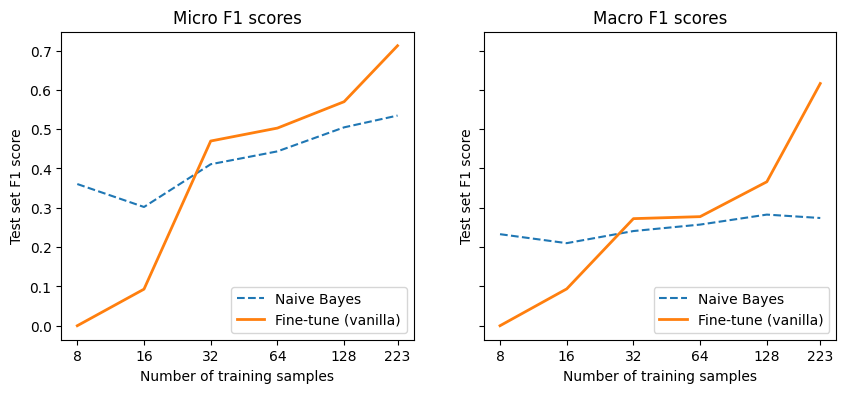

In [ ]:
plot_metrics(micro_scores, macro_scores, train_samples, "Fine-tune (vanilla)")

### In-Context and Few-Shot learning with Prompts

In [ ]:
prompt = """\
Translate English to French:
thanks =>
"""

### Laveraging Unlabeled Data

#### Fine-Tuning a Language Model

In [30]:
import torch
from transformers import (AutoTokenizer, AutoConfig,
                          AutoModelForSequenceClassification)

model_ckpt = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:72: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [31]:
def tokenize(batch):
    return tokenizer(batch["text"], truncation=True,
                     max_length=128, return_special_tokens_mask=True)



In [32]:
ds_mlm = ds.map(tokenize, batched=True)
ds_mlm = ds_mlm.remove_columns(["labels", "text", "label_ids"])

Map:   0%|          | 0/223 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/111 [00:00<?, ? examples/s]

Map:   0%|          | 0/9303 [00:00<?, ? examples/s]

In [33]:
from transformers import DataCollatorForLanguageModeling, set_seed

data_collator = DataCollatorForLanguageModeling(tokenizer=tokenizer,
                                                mlm_probability=0.15)

In [36]:
set_seed(3)

data_collator.return_tensors="np" ### Numpy output format not pt -> pytorch
inputs = tokenizer("Transformers are awesome!", return_tensors="np")
outputs = data_collator([{"input_ids": inputs["input_ids"][0]}])

In [37]:
original_input_ids = inputs["input_ids"][0]
masked_input_ids = outputs["input_ids"][0]

In [38]:
import pandas as pd

pd.DataFrame({
    "Original tokens": tokenizer.convert_ids_to_tokens(original_input_ids),
    "Masked tokens": tokenizer.convert_ids_to_tokens(masked_input_ids),
    "Original input_ids": original_input_ids,
    "Masked input_ids": masked_input_ids,
    "Labels": outputs["labels"][0]
}).T

,0,1,2,3,4,5
Original tokens,[CLS],transformers,are,awesome,!,[SEP]
Masked tokens,[CLS],transformers,are,awesome,[MASK],[SEP]
Original input_ids,101,19081,2024,12476,999,102
Masked input_ids,101,19081,2024,12476,103,102
Labels,-100,-100,-100,-100,999,-100


In [39]:
data_collator.return_tensors="pt"

In [41]:
from transformers import TrainingArguments, Trainer
from transformers import AutoModelForMaskedLM

training_args = TrainingArguments(output_dir=f"{model_ckpt}-issues-128",
                                  per_device_train_batch_size=32,
                                  logging_strategy="epoch",
                                  evaluation_strategy="epoch",
                                  save_strategy="no",
                                  num_train_epochs=16,
                                  push_to_hub=True,
                                  log_level="error",
                                  report_to="none")

trainer = Trainer(model=AutoModelForMaskedLM.from_pretrained("bert-base-uncased"),
                  tokenizer=tokenizer,
                  args=training_args,
                  data_collator=data_collator,
                  train_dataset=ds_mlm["unsup"],
                  eval_dataset=ds_mlm["train"])

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:72: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [42]:
trainer.train()

Epoch,Training Loss,Validation Loss
1,2.095900,1.689251
2,1.632800,1.521055
3,1.492100,1.355438
4,1.401100,1.342415
5,1.335100,1.261350
6,1.271800,1.349058
7,1.221600,1.286704
8,1.206000,1.336526
9,1.178100,1.207189
10,1.133800,1.164344


TrainOutput(global_step=4656, training_loss=1.2804079285192327, metrics={'train_runtime': 4272.7044, 'train_samples_per_second': 34.837, 'train_steps_per_second': 1.09, 'total_flos': 9794377493913600.0, 'train_loss': 1.2804079285192327, 'epoch': 16.0})

In [43]:
trainer.push_to_hub("Training complete!")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:72: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

training_args.bin:   0%|          | 0.00/4.60k [00:00<?, ?B/s]

Upload 2 LFS files:   0%|          | 0/2 [00:00<?, ?it/s]

CommitInfo(commit_url='https://huggingface.co/MohamedAhmedAE/bert-base-uncased-issues-128/commit/1064e3772c958afd40102ddb468e0791ed26a4b8', commit_message='Training complete!', commit_description='', oid='1064e3772c958afd40102ddb468e0791ed26a4b8', pr_url=None, pr_revision=None, pr_num=None)

In [47]:
df_log.dropna(subset=["eval_loss"]).reset_index()

,index,loss,learning_rate,epoch,step,eval_loss,eval_runtime,eval_samples_per_second,eval_steps_per_second,train_runtime,train_samples_per_second,train_steps_per_second,total_flos,train_loss
0,1,NaN,NaN,1.0,291,1.689251,2.7825,80.143,10.063,NaN,NaN,NaN,NaN,NaN
1,3,NaN,NaN,2.0,582,1.521055,2.2918,97.303,12.217,NaN,NaN,NaN,NaN,NaN
2,5,NaN,NaN,3.0,873,1.355438,3.7346,59.712,7.497,NaN,NaN,NaN,NaN,NaN
3,7,NaN,NaN,4.0,1164,1.342415,2.6753,83.354,10.466,NaN,NaN,NaN,NaN,NaN
4,9,NaN,NaN,5.0,1455,1.261350,2.3105,96.514,12.118,NaN,NaN,NaN,NaN,NaN
5,11,NaN,NaN,6.0,1746,1.349058,2.2865,97.529,12.246,NaN,NaN,NaN,NaN,NaN
6,13,NaN,NaN,7.0,2037,1.286704,2.3356,95.479,11.988,NaN,NaN,NaN,NaN,NaN
7,15,NaN,NaN,8.0,2328,1.336526,2.2858,97.559,12.250,NaN,NaN,NaN,NaN,NaN
8,17,NaN,NaN,9.0,2619,1.207189,2.2825,97.700,12.267,NaN,NaN,NaN,NaN,NaN
9,19,NaN,NaN,10.0,2910,1.164344,2.3371,95.416,11.980,NaN,NaN,NaN,NaN,NaN


<function matplotlib.pyplot.show(close=None, block=None)>

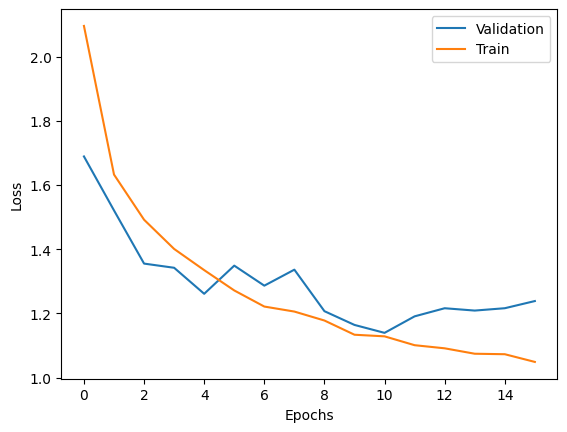

In [48]:
import matplotlib.pyplot as plt

df_log = pd.DataFrame(trainer.state.log_history)

(df_log.dropna(subset=["eval_loss"]).reset_index()["eval_loss"].plot(label="Validation"))
df_log.dropna(subset=["loss"]).reset_index()["loss"].plot(label="Train")

plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(loc="upper right")
plt.show

In [49]:
from transformers import AutoConfig

model_ckpt = f"{model_ckpt}-issues-128"
config = AutoConfig.from_pretrained(model_ckpt)
config.num_labels = len(all_labels)
config.problem_type = "multi_label_classification"

In [65]:
from transformers import AutoModelForSequenceClassification

for train_slice in train_slices:
    model = AutoModelForSequenceClassification.from_pretrained(model_ckpt,
                                                               config=config)

    trainer = Trainer(model=model,
                      tokenizer=tokenizer,
                      args=training_args_fine_tune,
                      compute_metrics=compute_metrics,
                      train_dataset=ds_enc["train"].select(train_slice),
                      eval_dataset=ds_enc["valid"])

    trainer.train()
    pred = trainer.predict(ds_enc["test"])
    metrics = compute_metrics(pred)

    # DA refers to domain adaption
    macro_scores["Fine-tune (DA)"].append(metrics["macro f1"])
    micro_scores["Fine-tune (DA)"].append(metrics["micro f1"])

{'loss': 0.6669, 'learning_rate': 3e-05, 'epoch': 1.0}
{'eval_loss': 0.6102617979049683, 'eval_micro f1': 0.15902140672782875, 'eval_macro f1': 0.09004386643111892, 'eval_runtime': 0.7603, 'eval_samples_per_second': 139.425, 'eval_steps_per_second': 5.261, 'epoch': 1.0}
{'loss': 0.5967, 'learning_rate': 3e-05, 'epoch': 2.0}
{'eval_loss': 0.5727061629295349, 'eval_micro f1': 0.031007751937984496, 'eval_macro f1': 0.03703703703703704, 'eval_runtime': 0.6964, 'eval_samples_per_second': 152.217, 'eval_steps_per_second': 5.744, 'epoch': 2.0}
{'loss': 0.545, 'learning_rate': 3e-05, 'epoch': 3.0}
{'eval_loss': 0.5265792608261108, 'eval_micro f1': 0.0, 'eval_macro f1': 0.0, 'eval_runtime': 0.6842, 'eval_samples_per_second': 154.919, 'eval_steps_per_second': 5.846, 'epoch': 3.0}
{'loss': 0.4866, 'learning_rate': 3e-05, 'epoch': 4.0}
{'eval_loss': 0.48958835005760193, 'eval_micro f1': 0.0, 'eval_macro f1': 0.0, 'eval_runtime': 0.6817, 'eval_samples_per_second': 155.483, 'eval_steps_per_second': 

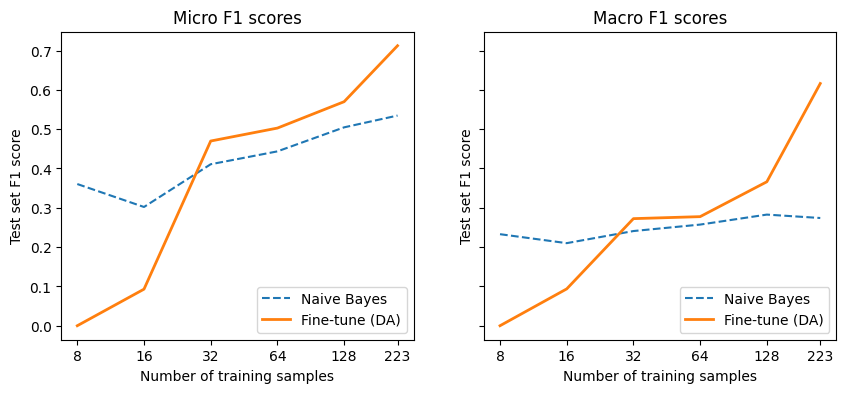

In [66]:
plot_metrics(micro_scores, macro_scores, train_samples, "Fine-tune (DA)")

### Advanced Methods


#### Unsupervised data augmentation


#### Uncertainty-aware self-training
